<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#What-if-we-have-change-in-variance,-but-guarantee-same-support" data-toc-modified-id="What-if-we-have-change-in-variance,-but-guarantee-same-support-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>What if we have change in variance, but guarantee same support</a></span><ul class="toc-item"><li><span><a href="#Building-a-curve" data-toc-modified-id="Building-a-curve-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Building a curve</a></span></li></ul></li><li><span><a href="#Bootstrapping-with-different-proportions-from-t=1-and-t=2" data-toc-modified-id="Bootstrapping-with-different-proportions-from-t=1-and-t=2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Bootstrapping with different proportions from t=1 and t=2</a></span></li><li><span><a href="#What-if-X_2-doesn't-change-during-the-training-time?" data-toc-modified-id="What-if-X_2-doesn't-change-during-the-training-time?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>What if X_2 doesn't change during the training time?</a></span></li></ul></div>

# Motivating example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from models.time_robust_forest import RandomTimeSplitTree
from time_robust_forest.models import TimeForestClassifier, TimeForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from models.decision_tree import DecisionTree

pd.set_option('mode.chained_assignment', None)

In [2]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [3]:
set_style()

# Data

In [4]:
np.random.seed(18)
POPULATION = 20000
features = ["x_1", "x_2"]
environment = "period"
target = "y"

In [5]:
periods = [0.1, 1]
data = pd.DataFrame()
data["period"] = np.concatenate([int(POPULATION/2) * [period] for period in periods],
                               axis=0)
data["x_1"] = data.apply(lambda x: np.random.normal(0, 1), axis=1)
data["y"] = data.apply(lambda x: 1 * x["x_1"] + np.random.normal(0, 1) * x["period"], axis=1)

x_2_period_function = {"0.1": data[data["period"] == 0.1]["y"].values + np.random.normal(0, 1, size=int(POPULATION/2)),
                       "1": np.random.normal(0, 1, size=int(POPULATION/2))}

for period in periods:
    data.loc[data["period"] == period, "x_2"] = x_2_period_function[str(period)]

for period in periods:
    mm = MinMaxScaler()
    data.loc[data["period"] == period, "x_2"] = mm.fit_transform(data[data["period"] == period][["x_2"]])[:, 0]

In [6]:
data.groupby("period")["x_2"].mean()

period
0.1    0.498920
1.0    0.553583
Name: x_2, dtype: float64

In [7]:
periods = [0.05, 0.02, 0.5, 1.2]
unseen_environments = periods
unseen_data = pd.DataFrame()
unseen_data["period"] = np.concatenate([int(POPULATION/2) * [period] for period in periods],
                               axis=0)
unseen_data["x_1"] = unseen_data.apply(lambda x: np.random.normal(0, 1) * x["period"], axis=1)
unseen_data["y"] = unseen_data.apply(lambda x: 1 * x["x_1"] + np.random.normal(0, 1) * x["period"], axis=1)
unseen_data["x_2"] = unseen_data.apply(lambda x: np.random.normal(0, 1), axis=1)

<AxesSubplot:xlabel='x_1', ylabel='Count'>

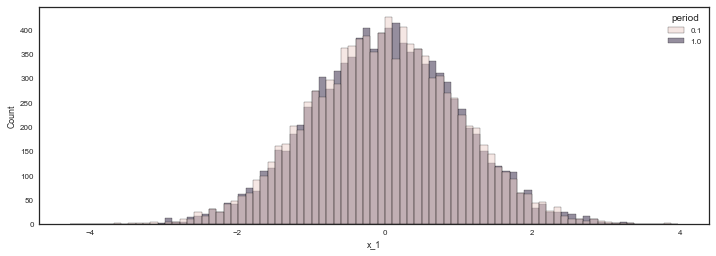

In [8]:
sns.histplot(data=data, x="x_1", hue="period")

<AxesSubplot:xlabel='x_2', ylabel='Count'>

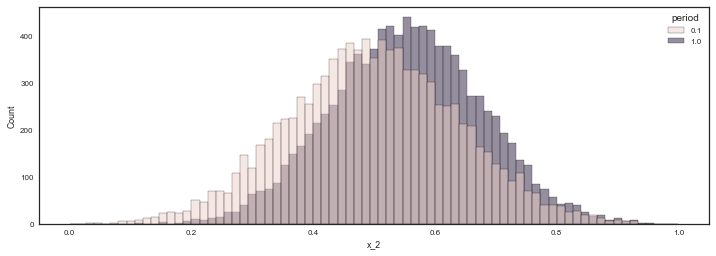

In [9]:
sns.histplot(data=data, x="x_2", hue="period")

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data[features + [environment]], 
                                                    data[target],
                                                    test_size=0.5,
                                                    stratify=data[environment],
                                                    random_state=42)

X_unseen = unseen_data[features + [environment]].values
y_unseen = unseen_data[target]

X = X_train[["x_1", "x_2", "period"]].values
X_test = X_test.values
y = y_train.values

print(X_train.shape)
print(X_test.shape)
print(X_unseen.shape)
print(y_train.shape)
print(y_test.shape)
print(y_unseen.shape)

(10000, 3)
(10000, 3)
(40000, 3)
(10000,)
(10000,)
(40000,)


In [11]:
time_tree_period_column = "period"

model_challenger = RandomTimeSplitTree(X_train[features + [time_tree_period_column]].reset_index(drop=True),
                                 y_train.values,
                                 max_depth=30,
                                 max_features=1.0,
                                 bootstrapping=False,
                                 time_column=time_tree_period_column,
                                 min_sample_periods=100,
                                 verbose=False)

In [12]:
model_challenger.feature_importance

x_1    32
x_2     2
Name: Feature Importance, dtype: int64

As we increase `min_sample_periods`, the algorithm picks only x_1, as it becomes less likely we can find invariant x_2 in the different periods with a higher volume of data. 

## What if we have change in variance, but guarantee same support

In [13]:
population_dict = {"0.1": int(POPULATION / 10),
                   "1": 9 * int(POPULATION / 10)}

In [14]:
# periods = [0.1, 1]
# data = pd.DataFrame()
# data["period"] = np.concatenate([population_dict[str(period)] * [period] for period in periods],
#                                 axis=0)
# data["x_1"] = data.apply(lambda x: np.random.normal(0, 1) * x["period"], axis=1)
# data["y"] = data.apply(lambda x: 1 * x["x_1"] + np.random.normal(0, 1) * x["period"], axis=1)

# x_2_period_function = {"0.1": data[data["period"] == 0.1]["y"].values + np.random.normal(0, 0.1, size=population_dict["0.1"]),
#                        "1": np.random.normal(0, 1, size=population_dict["1"])}

# x_2_period_function = {"0.1": data[data["period"] == 0.1]["y"].values,
#                        "1": np.random.normal(0, 1, size=population_dict["1"])}

# for period in periods:
#     data.loc[data["period"] == period, "x_2"] = x_2_period_function[str(period)]
    
# unseen_environments = [0.05, 0.02, 0.5, 1.2]
# unseen_data = pd.DataFrame()
# unseen_data["period"] = np.concatenate([int(POPULATION/4) * [period] for period in unseen_environments],
#                                axis=0)
# unseen_data["x_1"] = unseen_data.apply(lambda x: np.random.normal(0, 1) * x["period"], axis=1)
# unseen_data["y"] = unseen_data.apply(lambda x: 1 * x["x_1"] + np.random.normal(0, 1) * x["period"], axis=1)
# unseen_data["x_2"] = unseen_data.apply(lambda x: np.random.normal(0, 1), axis=1)    

In [15]:
periods = [0.1, 1]
data = pd.DataFrame()
data["period"] = np.concatenate([population_dict[str(period)] * [period] for period in periods],
                                axis=0)
data["x_1"] = data.apply(lambda x: np.random.normal(0, 1), axis=1)
data["y"] = data.apply(lambda x: 1 * x["x_1"] + np.random.normal(0, 1), axis=1)

x_2_period_function = {"0.1": data[data["period"] == 0.1]["y"].values + np.random.normal(0, 1, size=population_dict["0.1"]),
                       "1": np.random.normal(0, 1, size=population_dict["1"])}

x_2_period_function = {"0.1": data[data["period"] == 0.1]["y"].values,
                       "1": np.random.normal(0, 1, size=population_dict["1"])}

for period in periods:
    data.loc[data["period"] == period, "x_2"] = x_2_period_function[str(period)]
    
unseen_environments = [0.05, 0.02, 0.5, 1.2]
unseen_data = pd.DataFrame()
unseen_data["period"] = np.concatenate([int(POPULATION/4) * [period] for period in unseen_environments],
                               axis=0)
unseen_data["x_1"] = unseen_data.apply(lambda x: np.random.normal(0, 1), axis=1)
unseen_data["y"] = unseen_data.apply(lambda x: 1 * x["x_1"] + np.random.normal(0, 1), axis=1)
unseen_data["x_2"] = unseen_data.apply(lambda x: np.random.normal(0, 1), axis=1)    

In [16]:
data["Period (environment)"] = data["period"].apply(lambda x: 1 if x == 0.1 else 2)

In [17]:
# fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 4))

# sns.histplot(data=data, x="x_1", hue="Period (environment)", ax=axs[0], color=["blue", "green"])
# axs[0].set_xlabel("X_1", fontsize=12)
# axs[0].set_xlim([-3, 3])


# sns.histplot(data=data, x="x_2", hue="Period (environment)", ax=axs[1])
# axs[1].set_xlabel("X_2", fontsize=12)
# axs[1].set_xlim([-3, 3])

# xmin, xmax, ymin, ymax = plt.axis()


# plt.subplots_adjust(hspace=0.4)
# fig.tight_layout(pad=2)
# plt.legend(fontsize=18, bbox_to_anchor=(1.0, 1.0))

# plt.savefig('../images/synthetic_support_problem.eps', format='eps')

In [18]:
# for period in periods:
#     mm = MinMaxScaler()
#     data.loc[data["period"] == period, "x_1"] = mm.fit_transform(data[data["period"] == period][["x_1"]])[:, 0]
#     data.loc[data["period"] == period, "x_2"] = mm.fit_transform(data[data["period"] == period][["x_2"]])[:, 0]
    

# for period in unseen_environments:
#     mm = MinMaxScaler()
#     unseen_data.loc[unseen_data["period"] == period, "x_1"] = mm.fit_transform(unseen_data[unseen_data["period"] == period][["x_1"]])[:, 0]
#     unseen_data.loc[unseen_data["period"] == period, "x_2"] = mm.fit_transform(unseen_data[unseen_data["period"] == period][["x_2"]])[:, 0]    

In [19]:
for period in periods:
    mm = StandardScaler()
    data.loc[data["period"] == period, "x_1"] = mm.fit_transform(data[data["period"] == period][["x_1"]])[:, 0]
    data.loc[data["period"] == period, "x_2"] = mm.fit_transform(data[data["period"] == period][["x_2"]])[:, 0]
    

for period in unseen_environments:
    mm = StandardScaler()
    unseen_data.loc[unseen_data["period"] == period, "x_1"] = mm.fit_transform(unseen_data[unseen_data["period"] == period][["x_1"]])[:, 0]
    unseen_data.loc[unseen_data["period"] == period, "x_2"] = mm.fit_transform(unseen_data[unseen_data["period"] == period][["x_2"]])[:, 0]    

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data[features + [environment]], 
                                                    data[target],
                                                    test_size=0.5,
                                                    stratify=data[environment],
                                                    random_state=42)

X_unseen = unseen_data[features + [environment]]#.values
y_unseen = unseen_data[target]

X = X_train[["x_1", "x_2", "period"]].values
X_test = X_test#.values
y = y_train.values

print(X_train.shape)
print(X_test.shape)
print(X_unseen.shape)
print(y_train.shape)
print(y_test.shape)
print(y_unseen.shape)

(10000, 3)
(10000, 3)
(20000, 3)
(10000,)
(10000,)
(20000,)


In [21]:
time_tree_period_column = "period"

model_challenger = RandomTimeSplitTree(X_train[features + [time_tree_period_column]].reset_index(drop=True),
                                 y_train.values,
                                 max_depth=7,
                                 max_features=1.0,
                                 bootstrapping=False,
                                 time_column=time_tree_period_column,
                                 min_sample_periods=200,
                                 verbose=True)

Depth: 0
Max Depth: 7
Node periods distribution
0.1    1000
1.0    9000
Name: period, dtype: int64
Depth: 1
Max Depth: 7
Node periods distribution
0.1     497
1.0    4476
Name: period, dtype: int64
Depth: 2
Max Depth: 7
Node periods distribution
0.1     234
1.0    1191
Name: period, dtype: int64
Depth: 2
Max Depth: 7
Node periods distribution
0.1     263
1.0    3285
Name: period, dtype: int64
Depth: 1
Max Depth: 7
Node periods distribution
0.1     503
1.0    4524
Name: period, dtype: int64
Depth: 2
Max Depth: 7
Node periods distribution
0.1     273
1.0    3302
Name: period, dtype: int64
Depth: 2
Max Depth: 7
Node periods distribution
0.1     230
1.0    1222
Name: period, dtype: int64


In [22]:
model_challenger.feature_importance

x_2    2
x_1    1
Name: Feature Importance, dtype: int64

In [23]:
model_challenger.predict(X_unseen[features])

array([ 0.73812843,  0.73812843,  0.73812843, ..., -0.72548731,
       -0.72548731,  0.73812843])

In [24]:
mean_squared_error(y_unseen, model_challenger.predict(X_unseen[features]))

1.3795230133023748

In [25]:
y_train.mean()

0.0034630326328701656

In [26]:
mean_squared_error(y_unseen, [y_train.mean()] * len(y_unseen))

1.9946548419375514

In [27]:
model = TimeForestRegressor(time_column="period", 
                            n_estimators=1, 
                            bootstrapping=False,
                            max_features=1.0,
                            period_criterion='avg')

#model = TimeForestRegressor(time_column="period")
model.fit(X_train[features + [time_tree_period_column]].reset_index(drop=True),
                                 y_train.values)

In [28]:
mean_squared_error(y_unseen, model.predict(X_unseen[features]))

1.3363360989984878

In [29]:
model.feature_importance()

x_2    3
x_1    3
Name: Feature Importance, dtype: int64

More regularization is needed, but it gets there. 

In [30]:
time_tree_period_column = "period"

model_benchmark = DecisionTree(X_train[features + [time_tree_period_column]].reset_index(drop=True),
                                 y_train.values,
                                 max_depth=7,
                                 min_leaf=200,
                                 verbose=True,
                                 time_column="period")

Depth: 0
Max Depth: 7
Node periods distribution
0.1    1000
1.0    9000
Name: period, dtype: int64
Depth: 1
Max Depth: 7
Node periods distribution
0.1     497
1.0    4476
Name: period, dtype: int64
Depth: 2
Max Depth: 7
Node periods distribution
0.1     181
1.0    1598
Name: period, dtype: int64
Depth: 3
Max Depth: 7
Node periods distribution
0.1     54
1.0    514
Name: period, dtype: int64
Depth: 4
Max Depth: 7
Node periods distribution
0.1     23
1.0    192
Name: period, dtype: int64
Depth: 4
Max Depth: 7
Node periods distribution
0.1     31
1.0    322
Name: period, dtype: int64
Depth: 3
Max Depth: 7
Node periods distribution
0.1     127
1.0    1084
Name: period, dtype: int64
Depth: 4
Max Depth: 7
Node periods distribution
0.1     56
1.0    203
Name: period, dtype: int64
Depth: 4
Max Depth: 7
Node periods distribution
0.1     71
1.0    881
Name: period, dtype: int64
Depth: 5
Max Depth: 7
Node periods distribution
0.1     20
1.0    216
Name: period, dtype: int64
Depth: 5
Max Depth: 7


### Building a curve

<AxesSubplot:xlabel='x_1', ylabel='Count'>

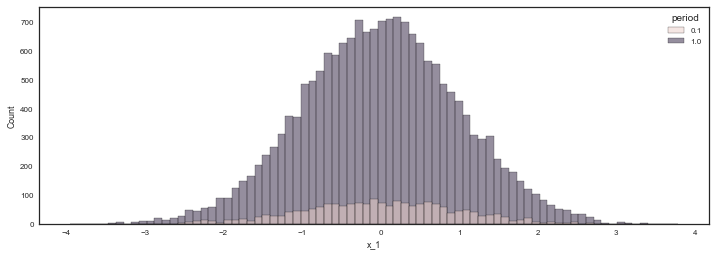

In [31]:
sns.histplot(data=data, x="x_1", hue="period")

<AxesSubplot:xlabel='x_2', ylabel='Count'>

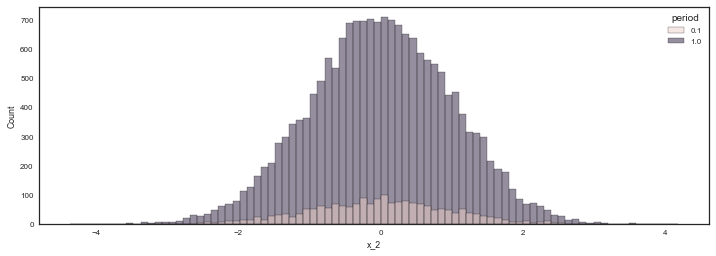

In [32]:
sns.histplot(data=data, x="x_2", hue="period")

In [33]:
min_sample_by_period_range = np.linspace(1, 500, 10, dtype=int)

In [34]:
y_train.mean()

0.0034630326328701656

In [35]:
mean_squared_error(y_unseen, [y_train.mean()] * len(y_unseen))

1.9946548419375514

In [36]:
importances = []
performances = []
test_performances = []
bench_performances = []
bench_test_performances = []
bench_importances = []
max_depth = 10

for min_sample in min_sample_by_period_range:
    model_challenger = RandomTimeSplitTree(X_train[features + [time_tree_period_column]].reset_index(drop=True),
                                 y_train.values,
                                 max_depth=max_depth,
                                 max_features=1.0,
                                 bootstrapping=False,
                                 min_leaf=2*min_sample,
                                 time_column=time_tree_period_column,
                                 min_sample_periods=min_sample,
                                 verbose=False)
    
    imp = model_challenger.feature_importance
    
    imp = imp / sum(imp)
    df = pd.DataFrame(imp).transpose()

    df["min_sample"] = min_sample
    importances.append(df)
    
    performances.append(mean_squared_error(y_unseen, model_challenger.predict(X_unseen[features])))
    test_performances.append(mean_squared_error(y_test, model_challenger.predict(X_test[features])))
    
    model = DecisionTree(X_train[features].reset_index(drop=True),
                         y_train.values, max_depth=max_depth, min_leaf=2*min_sample)
    bench_performances.append(mean_squared_error(y_unseen, model.predict(X_unseen[features])))
    bench_test_performances.append(mean_squared_error(y_test, model.predict(X_test[features])))
    
    imp = model.feature_importance
    
    imp = imp / sum(imp)
    df = pd.DataFrame(imp).transpose()

    df["min_sample"] = min_sample
    bench_importances.append(df)

In [37]:
bench_importances_by_param = pd.concat(bench_importances)
bench_importances_by_param.index = bench_importances_by_param["min_sample"]
bench_importances_by_param.drop(columns=["min_sample"], inplace=True)
bench_importances_by_param.fillna(0, inplace=True)
bench_importances_by_param

,x_1,x_2
min_sample,,
1,0.502340,0.497660
56,0.507246,0.492754
111,0.617647,0.382353
167,0.681818,0.318182
222,0.750000,0.250000
278,0.692308,0.307692
333,0.800000,0.200000
389,0.888889,0.111111
444,0.888889,0.111111


In [38]:
importances_by_param = pd.concat(importances)
importances_by_param.index = importances_by_param["min_sample"]
importances_by_param.drop(columns=["min_sample"], inplace=True)
importances_by_param.fillna(0, inplace=True)
importances_by_param["performance"] = performances
importances_by_param["bench_performance"] = bench_performances
importances_by_param["test_performance"] = test_performances
importances_by_param["bench_test_performance"] = bench_test_performances
importances_by_param

,x_2,x_1,performance,bench_performance,test_performance,bench_test_performance
min_sample,,,,,,
1,0.549515,0.450485,1.167788,1.183585,1.132476,1.184395
56,0.545455,0.454545,1.248129,1.032178,1.225005,1.023135
111,0.571429,0.428571,1.314241,1.028498,1.278394,1.021465
167,0.666667,0.333333,1.379523,1.029955,1.345559,1.028419
222,0.666667,0.333333,1.379523,1.035732,1.345559,1.034353
278,0.000000,1.000000,1.368174,1.041567,1.355704,1.039186
333,0.000000,1.000000,1.368174,1.042338,1.355704,1.044786
389,0.000000,1.000000,1.368174,1.043235,1.355704,1.051543
444,0.000000,1.000000,1.368174,1.043959,1.355704,1.052404


In [39]:
importances_by_param.iloc[importances_by_param["test_performance"].argmin(), :]

x_2                       0.549515
x_1                       0.450485
performance               1.167788
bench_performance         1.183585
test_performance          1.132476
bench_test_performance    1.184395
Name: 1, dtype: float64

In [40]:
importances_by_param.iloc[importances_by_param["bench_test_performance"].argmin(), :]

x_2                       0.571429
x_1                       0.428571
performance               1.314241
bench_performance         1.028498
test_performance          1.278394
bench_test_performance    1.021465
Name: 111, dtype: float64

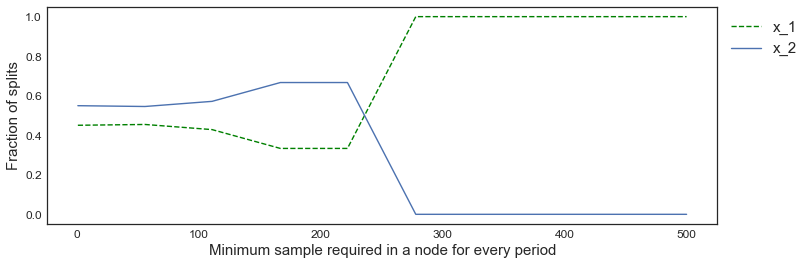

In [41]:
fig, ax = plt.subplots()
plt.plot(importances_by_param["x_1"], color="green", linestyle="dashed", label="x_1")
plt.plot(importances_by_param["x_2"], label="x_2", color="#4c72b0")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Fraction of splits", fontsize=15)
plt.xlabel("Minimum sample required in a node for every period", fontsize=15)
plt.savefig("../images/synthetic_min_sample.eps", format="eps", bbox_inches="tight")

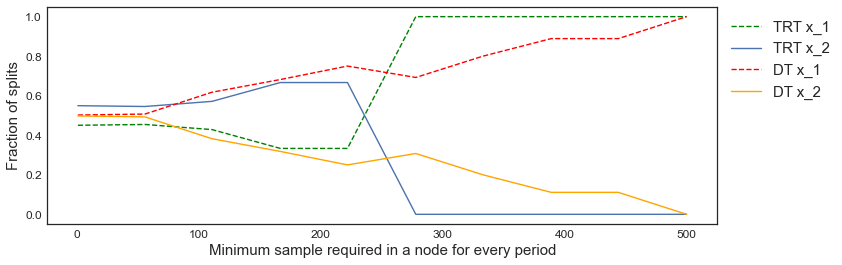

In [42]:
fig, ax = plt.subplots()
plt.plot(importances_by_param["x_1"], color="green", linestyle="dashed", label="TRT x_1")
plt.plot(importances_by_param["x_2"], label="TRT x_2", color="#4c72b0")

plt.plot(bench_importances_by_param["x_1"], color="red", linestyle="dashed", label="DT x_1")
plt.plot(bench_importances_by_param["x_2"], label="DT x_2", color="orange")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Fraction of splits", fontsize=15)
plt.xlabel("Minimum sample required in a node for every period", fontsize=15)
plt.savefig("../images/synthetic_min_sample_dt.eps", format="eps", bbox_inches="tight")

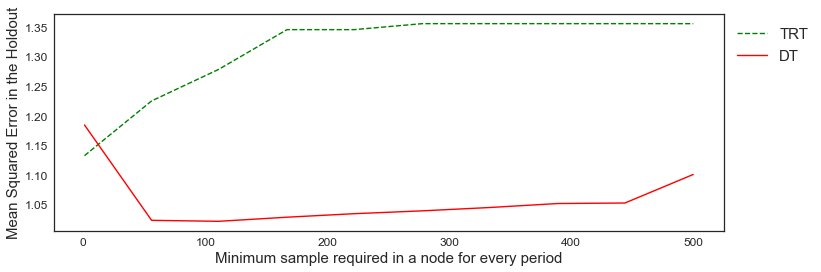

In [43]:
fig, ax = plt.subplots()
plt.plot(importances_by_param["test_performance"], color="green", linestyle="dashed", label="TRT")
plt.plot(importances_by_param["bench_test_performance"], color="red", label="DT")
#plt.plot(importances_by_param["x_2"], label="x_2", color="#4c72b0")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Mean Squared Error in the Holdout", fontsize=15)
plt.xlabel("Minimum sample required in a node for every period", fontsize=15)
plt.savefig("../images/synthetic_performance_test.eps", format="eps", bbox_inches="tight")

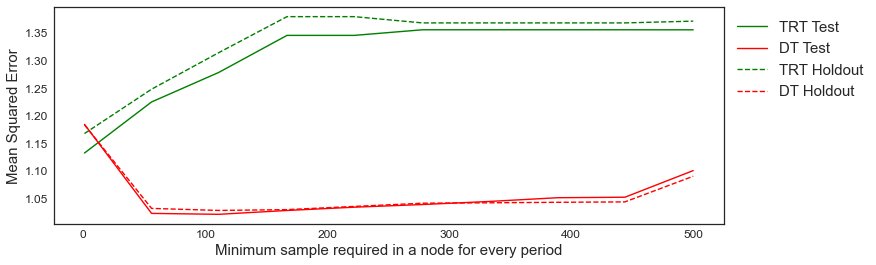

In [44]:
fig, ax = plt.subplots()
plt.plot(importances_by_param["test_performance"], color="green", label="TRT Test")
plt.plot(importances_by_param["bench_test_performance"], color="red", label="DT Test")

plt.plot(importances_by_param["performance"], color="green", linestyle="dashed", label="TRT Holdout")
plt.plot(importances_by_param["bench_performance"], color="red", linestyle="dashed", label="DT Holdout")
#plt.plot(importances_by_param["x_2"], label="x_2", color="#4c72b0")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Mean Squared Error", fontsize=15)
plt.xlabel("Minimum sample required in a node for every period", fontsize=15)
plt.savefig("../images/synthetic_performance_both.eps", format="eps", bbox_inches="tight")

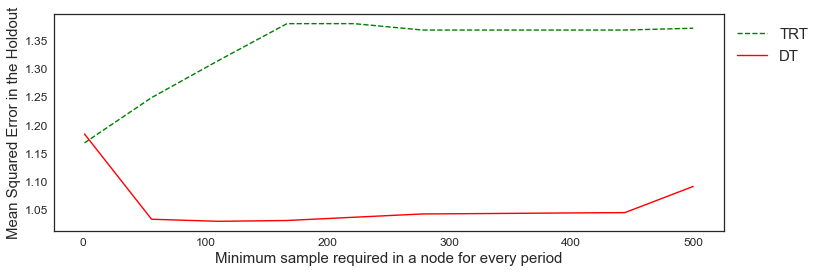

In [45]:
fig, ax = plt.subplots()
plt.plot(importances_by_param["performance"], color="green", linestyle="dashed", label="TRT")
plt.plot(importances_by_param["bench_performance"], color="red", label="DT")
#plt.plot(importances_by_param["x_2"], label="x_2", color="#4c72b0")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Mean Squared Error in the Holdout", fontsize=15)
plt.xlabel("Minimum sample required in a node for every period", fontsize=15)
plt.savefig("../images/synthetic_performance.eps", format="eps", bbox_inches="tight")

## Bootstrapping with different proportions from t=1 and t=2

In [46]:
def create_dataset(w_1, w_2, population=1000):
    population_dict = {"0.1": w_1 * int(population / (w_1 + w_2)),
                       "1": w_2 * int(population / (w_1 + w_2))}
    periods = [0.1, 1]
    data = pd.DataFrame()
    data["period"] = np.concatenate([population_dict[str(period)] * [period] for period in periods],
                                    axis=0)
    data["x_1"] = data.apply(lambda x: np.random.normal(0, 1) * x["period"], axis=1)
    data["y"] = data.apply(lambda x: 1 * x["x_1"] + np.random.normal(0, 1) * x["period"], axis=1)

    x_2_period_function = {"0.1": data[data["period"] == 0.1]["y"].values + np.random.normal(0, 0.1, size=population_dict["0.1"]),
                           "1": np.random.normal(0, 1, size=population_dict["1"])}

    x_2_period_function = {"0.1": data[data["period"] == 0.1]["y"].values,
                           "1": np.random.normal(0, 1, size=population_dict["1"])}

    for period in periods:
        data.loc[data["period"] == period, "x_2"] = x_2_period_function[str(period)]
        
    
    for period in periods:
        mm = MinMaxScaler()
        data.loc[data["period"] == period, "x_1"] = mm.fit_transform(data[data["period"] == period][["x_1"]])[:, 0]
        data.loc[data["period"] == period, "x_2"] = mm.fit_transform(data[data["period"] == period][["x_2"]])[:, 0]
    
    periods = [0.05, 0.02, 0.5, 1.2]
    unseen_environments = periods
    unseen_data = pd.DataFrame()
    unseen_data["period"] = np.concatenate([population * [period] for period in periods],
                                   axis=0)
    unseen_data["x_1"] = unseen_data.apply(lambda x: np.random.normal(0, 1) * x["period"], axis=1)
    unseen_data["y"] = unseen_data.apply(lambda x: 1 * x["x_1"] + np.random.normal(0, 1) * x["period"], axis=1)
    unseen_data["x_2"] = unseen_data.apply(lambda x: np.random.normal(0, 1), axis=1)

    for period in unseen_environments:
        mm = MinMaxScaler()
        unseen_data.loc[unseen_data["period"] == period, "x_1"] = mm.fit_transform(unseen_data[unseen_data["period"] == period][["x_1"]])[:, 0]
        unseen_data.loc[unseen_data["period"] == period, "x_2"] = mm.fit_transform(unseen_data[unseen_data["period"] == period][["x_2"]])[:, 0]    
        
    X_train, X_test, y_train, y_test = train_test_split(data[features + [environment]], 
                                                        data[target],
                                                        test_size=0.5,
                                                        stratify=data[environment],
                                                        random_state=42)

    X_unseen = unseen_data[features + [environment]]#.values
    y_unseen = unseen_data[target]

    X = X_train[["x_1", "x_2", "period"]].values
    X_test = X_test#.values
    y = y_train.values     
    
    return X_train.reset_index(drop=True), X_test, y, y_test, unseen_data

In [47]:
experiment_results = {}
experiment_results["result"] = {"benchmark": [], 
                                "challenger": []}  
n_rounds = 50
min_leafs = list(np.linspace(2, 550, 25, dtype=int))

for n_round in range(n_rounds):
    experiment_results[n_round] = {"benchmark": {}, 
                                   "challenger": {}}    
    weights = np.random.randint(1, 10, 2)
    X_train, X_test, y, y_test, unseen_data = create_dataset(weights[0],
                                                             weights[1])

    

    for model_type in ["benchmark", "challenger"]:
        experiment_results[n_round][model_type]["df"] = []
        experiment_results[n_round][model_type]["train"] = []
        experiment_results[n_round][model_type]["holdout"] = []
        experiment_results[n_round][model_type]["splits"] = []   
        
        
    for min_leaf in min_leafs:
        ### Benchmark model
        model_type = "benchmark"
        model = DecisionTree(X_train[["x_1", "x_2"]], y, max_depth=20, min_leaf=min_leaf)
        X_train["prediction"] = model.predict(X_train[features])
        n_splits = model.feature_importance.sum()
        experiment_results[n_round][model_type]["splits"].append(min_leaf)
        unseen_data["prediction"] = model.predict(unseen_data[features])
        experiment_results[n_round][model_type]["train"].append(mean_squared_error(y, X_train["prediction"]))
        experiment_results[n_round][model_type]["holdout"].append(mean_squared_error(unseen_data[target], 
                                                                                unseen_data["prediction"]))
        
 
        ### Challenger model
        model_type = "challenger"
        time_model_tree = RandomTimeSplitTree(X_train[["x_1", "x_2", "period"]], 
                                            y,
                                            time_column="period",
                                            max_depth=20,
                                            min_sample_periods=int(min_leaf/2),
                                            min_leaf=min_leaf,  
                                            verbose=False,
                                            split_verbose=False,
                                            bootstrapping=False,
                                            max_features=1.0,
                                            period_criterion="max")
        X_train["time_prediction"] = time_model_tree.predict(X_train)

        n_splits = time_model_tree.feature_importance.sum()
        experiment_results[n_round][model_type]["splits"].append(min_leaf)
        unseen_data["time_prediction"] = time_model_tree.predict(unseen_data[features])
        experiment_results[n_round][model_type]["train"].append(mean_squared_error(y, X_train["time_prediction"]))
        experiment_results[n_round][model_type]["holdout"].append(mean_squared_error(unseen_data[target], unseen_data["time_prediction"]))
        
    benchmark_df = pd.DataFrame(list(zip(experiment_results[n_round]["benchmark"]["train"],
                                experiment_results[n_round]["benchmark"]["holdout"],
                                experiment_results[n_round]["benchmark"]["splits"])), 
                                columns=["train", "holdout", "splits"])
    
    challenger_df = pd.DataFrame(list(zip(experiment_results[n_round]["challenger"]["train"],
                                 experiment_results[n_round]["challenger"]["holdout"],
                                 experiment_results[n_round]["challenger"]["splits"])), 
                                 columns=["train", "holdout", "splits"])
    
    benchmark_df.loc[:, "weight"] = str(weights)
    challenger_df.loc[:, "weight"] = str(weights)
    
    experiment_results["result"]["benchmark"].append(benchmark_df)
    experiment_results["result"]["challenger"].append(challenger_df)

In [48]:
benchmark_results = pd.concat(experiment_results["result"]["benchmark"])
benchmark_results["model"] = "benchmark"

challenger_results = pd.concat(experiment_results["result"]["challenger"])
challenger_results["model"] = "challenger"    

../images/synthetic_boot:22: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.


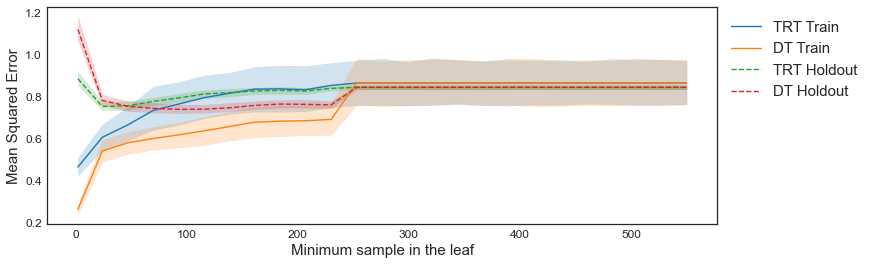

In [49]:
from matplotlib.collections import PolyCollection as p

fig, ax = plt.subplots()
sns.lineplot(data=challenger_results, x="splits", y="train", label="TRT Train")
sns.lineplot(data=benchmark_results, x="splits", y="train", label="DT Train")

sns.lineplot(data=challenger_results, x="splits", y="holdout", linestyle="dashed", label="TRT Holdout")
sns.lineplot(data=benchmark_results, x="splits", y="holdout", linestyle="dashed", label="DT Holdout")
plt.legend()

xmin, xmax, ymin, ymax = plt.axis()

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Mean Squared Error", fontsize=15)
#plt.xlabel("Minimum sample in the leaf (DT), minimum sample by period (TRT)", fontsize=15)
plt.xlabel("Minimum sample in the leaf", fontsize=15)

__file__ = "../images/synthetic_boot"
plt.savefig(__file__+".jpg", quality=95)
for c in ax.findobj(p):
    c.set_zorder(-1)
    c.set_rasterized(True)
ax.set_rasterization_zorder(0)

plt.savefig(__file__+".eps")

## What if X_2 doesn't change during the training time?

In [50]:
periods = [0.1, 1]
data = pd.DataFrame()
data["period"] = np.concatenate([int(POPULATION/2) * [period] for period in periods],
                               axis=0)
data["x_1"] = data.apply(lambda x: np.random.normal(0, 1) * x["period"], axis=1)
data["y"] = data.apply(lambda x: 1 * x["x_1"] + np.random.normal(0, 1) * x["period"], axis=1)
data["x_2"] = data.apply(lambda x: x["y"] + np.random.normal(0, 1), axis=1)

for period in periods:
    mm = MinMaxScaler()
    data.loc[data["period"] == period, "x_1"] = mm.fit_transform(data[data["period"] == period][["x_1"]])[:, 0]
    data.loc[data["period"] == period, "x_2"] = mm.fit_transform(data[data["period"] == period][["x_2"]])[:, 0]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(data[features + [environment]], 
                                                    data[target],
                                                    test_size=0.5,
                                                    stratify=data[environment],
                                                    random_state=42)

X_unseen = unseen_data[features + [environment]].values
y_unseen = unseen_data[target]

X = X_train[["x_1", "x_2", "period"]].values
X_test = X_test.values
y = y_train.values

print(X_train.shape)
print(X_test.shape)
print(X_unseen.shape)
print(y_train.shape)
print(y_test.shape)
print(y_unseen.shape)

(10000, 3)
(10000, 3)
(4000, 3)
(10000,)
(10000,)
(4000,)


In [52]:
model_challenger = RandomTimeSplitTree(X_train[features + [time_tree_period_column]].reset_index(drop=True),
                                 y_train.values,
                                 max_depth=30,
                                 max_features=1.0,
                                 bootstrapping=False,
                                 time_column=time_tree_period_column,
                                 min_sample_periods=100,
                                 verbose=False)

In [53]:
model_challenger.feature_importance

x_1    15
x_2    12
Name: Feature Importance, dtype: int64

It's unable to solve the exact same case from IRM, it depends on changes in the spurious variable during the training time.